<img src="https://raw.githubusercontent.com/paular143/images_notebooks/master/logo-sin-nombre.png" alt="Universidad de Los Andes" style="width: 90px;" align="left" frameborder="300"/>

**UNIVERSIDAD DE LOS ANDES** <br>
**FACULTAD DE ECONOMÍA - EDUCACIÓN CONTINUADA** <br>
**Análisis espacial de datos y sus aplicaciones en Python 2020** <br>
**PROFESORES:** Germán González y Mateo Dulce <br><br>


# Clase 5: Golocalización

- cuadrícula




In [1]:
# !pip3 install shapely
# !pip3 install pyproj
# !pip3 install folium
# !pip3 install pandas
# !pip3 install requests
# !pip3 install geopy
# !pip3 install geojson
# !pip3 install xlrd
# !pip3 install --upgrade git+https://github.com/m-wrzr/populartimes
import pyproj
from functools import partial
import shapely.geometry
from shapely.ops import transform
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point
import folium
import geojson
import json
import pandas as pd
import re
import geopy
import requests
import time
import numpy as np
from geopy.distance import geodesic
from geopy.geocoders import Nominatim

/Users/germangonzalez/.pyenv/versions/3.7.5/envs/motus/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
Latitud = 4.667095
Longitud = -74.052542

Para poder construir la cuadricula se requiere un sistema en metros

**Información del Sistema Geodésico Mundial 1984 (WGS84) en grados**
https://epsg.io/4326


**Información del Sistema Geodésico Mundial 1984 (WGS84) en metros**
https://epsg.io/3857

In [5]:
####### -------- Convertir a un sistema en donde la unidad es metros ------- #######
A_metros = partial(
    pyproj.transform,
    pyproj.Proj('EPSG:4326'),
    pyproj.Proj('EPSG:3857'))

###### ------- Inversa convertir a un sistema en donde la unidad es grados -------- ######## 
A_grados = partial(
    pyproj.transform,
    pyproj.Proj('EPSG:3857'),
    pyproj.Proj('EPSG:4326'))


### Resultado transformado

In [6]:
Transformacion_metros = transform(A_metros, Point(Latitud, Longitud)).coords[0]

In [7]:
Transformacion_metros

(-8243491.267387505, 520114.1262704485)

## Le sumamos 100 metros en las cordenadas transformadas en la escala de metros

In [8]:
Tamano_metros = 1000
Transformacion_grados = transform(A_grados, Point(Transformacion_metros[0] + Tamano_metros,Transformacion_metros[1] + Tamano_metros)).coords[0] 

In [9]:
##### ------- Mapa ----- #####
mapa = folium.Map(location=[Latitud,Longitud],zoom_start=15,tiles='cartodbpositron')
folium.Marker([Latitud,Longitud]).add_to(mapa)
folium.Marker([Transformacion_grados[0],Transformacion_grados[1]]).add_to(mapa)

In [10]:
mapa

# Cuadrícula 

In [11]:
mapa = folium.Map(location=[Latitud,Longitud],zoom_start=15,tiles='cartodbpositron')
folium.Marker([Latitud,Longitud],icon=folium.Icon(icon='cloud',color='blue')).add_to(mapa)

#### ------- Latitud (arriba y abajo) -------- ######### 
arriba_derecha = transform(A_grados, Point(Transformacion_metros[0] + Tamano_metros,Transformacion_metros[1] + Tamano_metros)).coords[0] 
folium.Marker([arriba_derecha[0],arriba_derecha[1]],icon=folium.Icon(icon='cloud',color='red')).add_to(mapa)

abajo_derecha = transform(A_grados, Point(Transformacion_metros[0] + Tamano_metros,Transformacion_metros[1] - Tamano_metros)).coords[0] 
folium.Marker([abajo_derecha[0],abajo_derecha[1]],icon=folium.Icon(icon='cloud',color='green')).add_to(mapa)


#### ------- Longitud (derecha y izquierda) -------- ######### 
arriba_izquierda = transform(A_grados, Point(Transformacion_metros[0] - Tamano_metros,Transformacion_metros[1] + Tamano_metros)).coords[0] 
folium.Marker([arriba_izquierda[0],arriba_izquierda[1]],icon=folium.Icon(icon='cloud',color='darkpurple')).add_to(mapa)

abajo_izquierda = transform(A_grados, Point(Transformacion_metros[0] - Tamano_metros,Transformacion_metros[1] - Tamano_metros)).coords[0] 
folium.Marker([abajo_izquierda[0],abajo_izquierda[1]],icon=folium.Icon(icon='cloud',color='black')).add_to(mapa)


In [12]:
mapa

# Construir un cuadrado

In [16]:
#### -- Creamos una lista vacia ---- #### 
Latitud = 4.667095
Longitud = -74.052542
#### ---- Distance --- #### 
Tamano_metros = 5000
Transformacion_grados = transform(A_grados, Point(Transformacion_metros[0] + Tamano_metros,Transformacion_metros[1] + Tamano_metros)).coords[0] 



In [25]:
Diferencia_latitude

0.004476540384448668

In [26]:
#### -- Creamos una lista vacia ---- #### 
Latitud = 4.667095
Longitud = -74.052542
#### ---- Distance --- #### 
Tamano_metros = 5000
Transformacion_grados = transform(A_grados, Point(Transformacion_metros[0] + Tamano_metros,Transformacion_metros[1] + Tamano_metros)).coords[0] 

Figuras_json = []
Figuras_poligonos = []
Subcuadrados = 10

Latitud_inicial = Latitud
Latitud_final = Transformacion_grados[0]

###### ------ Se crea una malla entre la latitud inicial y latitud final a n subcuadrados ----- ######
Latitudes_cuadricula = np.linspace(Latitud_inicial, Latitud_final, Subcuadrados+1)
###### ------ Se crea una malla entre la longitud inicial y longitud final a n subcuadrados ----- ######
Longitudes_cuadricula = np.linspace(Longitud,Transformacion_grados[1], Subcuadrados+1)

#### ------- Total distancia ---------- #######
Diferencia_latitude = Latitudes_cuadricula[1] - Latitudes_cuadricula[0]
Diferencia_longitud = Longitudes_cuadricula[1] - Longitudes_cuadricula[0]

for lat in Latitudes_cuadricula[:-1]:
    for lon in Longitudes_cuadricula[:-1]:
        superior_derecha = [lon + Diferencia_longitud, lat + Diferencia_latitude]
        superior_izquierda = [lon, lat + Diferencia_latitude]
        inferior_derecha = [lon + Diferencia_longitud, lat]
        inferior_izquierda = [lon, lat]

        
        Figura = Polygon([
            list(superior_derecha),
            list(superior_izquierda),
            list(inferior_izquierda),
            list(inferior_derecha),
        ])

        
        
        Zona_analisis = geojson.Feature(geometry=Figura.buffer(0))

        Poligono = {
            'type': 'Feature',
            'geometry': { "type": Zona_analisis['geometry']['type'], "coordinates": Zona_analisis['geometry']['coordinates']},
            'properties' :  {"id": '1',"Municipio": 'Zona' } 
        }
        #### ---- A figuras se añade este poligono ---- ### 
        Figuras_json.append(Poligono)
        Figuras_poligonos.append(Figura)


    
##### --------- Se consolidan todos los polígonos como una colección de datos ------ ######  
Coleccion_json = {
    'type': 'FeatureCollection',
    'features': Figuras_json,
}

### ----  Verifica que la estructura sea correcta para JSON ----- #### 

#### ---- load ----- ##### 
geo_str = json.loads(json.dumps(Coleccion_json) )


# Graficar Mapa

In [27]:
Mapa = folium.Map(location=[Latitud,Longitud],zoom_start=14,tiles='cartodbpositron')

####----- Agregamos la capa geojson ---- #####
folium.GeoJson(geo_str,
style_function=lambda feature: {
    'fillColor': 'gray',
    'color': '#7d868c',
    'weight': 1,
    'fillOpacity':0.2,
},
highlight_function=lambda x: {'weight':10,'fillColor':'#fec821','color': '#fec821'},tooltip='Bogota',
name='Cuadricula').add_to(Mapa)

folium.LayerControl().add_to(Mapa)

In [28]:
Mapa

## Buscar puntos en esa malla

In [29]:
Consolidado_fuguras = pd.DataFrame({'Figura': Figuras_poligonos})
Consolidado_fuguras = Consolidado_fuguras.rename_axis('Cuadro').reset_index(drop=False)

In [30]:
Consolidado_fuguras

,Cuadro,Figura
0,0,POLYGON ((-74.04805042357941 4.671571540384448...
1,1,POLYGON ((-74.04355884715882 4.671571540384448...
2,2,POLYGON ((-74.03906727073822 4.671571540384448...
3,3,POLYGON ((-74.03457569431761 4.671571540384448...
4,4,POLYGON ((-74.03008411789702 4.671571540384448...
...,...,...
95,95,"POLYGON ((-74.02559254147643 4.71186040384449,..."
96,96,"POLYGON ((-74.02110096505582 4.71186040384449,..."
97,97,"POLYGON ((-74.01660938863522 4.71186040384449,..."
98,98,"POLYGON ((-74.01211781221463 4.71186040384449,..."


## Comercios de bogotá: Camara de Comercio 2016

In [31]:
Establecimientos_totales = pd.read_pickle('Datos/Comercios.gzip',compression='gzip')

In [32]:
Establecimientos_totales=Establecimientos_totales.reset_index(drop=True)

In [33]:
start_time = time.time()
Lugares = list(map(lambda y: Establecimientos_totales[Establecimientos_totales['Point'].apply(lambda x: x.within(y))] ,list(Consolidado_fuguras['Figura']) ))
print("--- %s seconds ---" % (time.time() - start_time))

--- 119.61796998977661 seconds ---


## Se remplazan el número de lugares dentro 

In [35]:
Consolidado_fuguras['Lugares_lento'] = Lugares 

In [36]:
Consolidado_fuguras.iloc[20]['Lugares_lento']

,Nombre,Actividad,Direccion,Latitude,Longitude,Point
4898,CORRAL GOURMET 93,Alojamiento y servicios de comida,Calle 93 A No. 12-57 Local 3 y 4,4.676404,-74.049152,POINT (-74.04915197202902 4.676403574428342)
5036,DEKO LOFT,Comercio al por mayor y al por menor; reparaci...,CL 95 NO. 13 81 LC NO. 2,4.680263,-74.048912,POINT (-74.04891224401905 4.680263286772344)
5911,FAMILI FARMACIAS,Actividades de atencionde la salud humana y de...,DG 127 A . 9A-60,4.678416,-74.050213,POINT (-74.05021339172434 4.678416213418295)
7178,CASA COMERCIAL LA 93,Comercio al por mayor y al por menor; reparaci...,CRA 15 NO. 93-60 LOC 1-24,4.677093,-74.051253,POINT (-74.05125340097317 4.677092760229707)
7179,VELEZ TRAVEL MAYORISTA,Actividades de servicios administrativos y de ...,CL 93 A NO. 14-37 OF 311,4.677093,-74.051253,POINT (-74.05125340097317 4.677092760229707)
...,...,...,...,...,...,...
439642,OPTICAS GMO COLOMBIA S.A.S,Comercio al por mayor y al por menor; reparaci...,CR 15 NO. 93 60 LC 117,4.677092,-74.051252,POINT (-74.05125246223371 4.677092348380687)
439644,I P S LABORATORIO CLINICO BEATRIZ HUERTAS LEON,Actividades de atencionde la salud humana y de...,KR 18 G 77 18 SUR,4.677092,-74.051252,POINT (-74.05125246223371 4.677092348380687)
439646,LINKOS,Comercio al por mayor y al por menor; reparaci...,CRA 15 NO. 93A-59,4.678488,-74.051248,POINT (-74.05124807665847 4.678487998562926)
439661,PINATERIA LUHER,Comercio al por mayor y al por menor; reparaci...,CL 93 B NO. 15 34 LC 204,4.678984,-74.051160,POINT (-74.05115967434966 4.678984022089987)


# Procesamiento en paralelo 

In [37]:
import multiprocessing
from multiprocess import Pool

start_time = time.time()
### ------- Cores ---- ####### 
CORES_PC = (multiprocessing.cpu_count()-1)
procesamiento = Pool(processes=CORES_PC)
##### ---------- Proceso --------- #######
Lugares = procesamiento.map(lambda y: Establecimientos_totales[Establecimientos_totales['Point'].apply(lambda x: x.within(y))],list(Consolidado_fuguras['Figura']))
######## ---------- Replace ---------- ########
print("--- %s seconds ---" % (time.time() - start_time))


--- 40.07706618309021 seconds ---


## Se remplazan el número de lugares dentro 

In [38]:
Consolidado_fuguras['Lugares_paralelo'] = Lugares 

# Mapa

In [39]:
Mapa = folium.Map(location=[Latitud,Longitud],zoom_start=14,tiles='cartodbpositron')

####----- Agregamos la capa geojson ---- #####
folium.GeoJson(geo_str,
style_function=lambda feature: {
    'fillColor': 'gray',
    'color': '#7d868c',
    'weight': 1,
    'fillOpacity':0.2,
},
highlight_function=lambda x: {'weight':10,'fillColor':'#fec821','color': '#fec821'},tooltip='Bogota',
name='Cudricula').add_to(Mapa)

folium.LayerControl().add_to(Mapa)

##### ------ Ejemplo cuadro k ----- ###### 
k = 1
Subcuadro = Consolidado_fuguras['Lugares_paralelo'].iloc[k].reset_index(drop=True)

for lugar in range(0,len(Subcuadro)):
    folium.Marker([Subcuadro.iloc[lugar]['Latitude'],Subcuadro.iloc[lugar]['Longitude']],tooltip=Subcuadro.iloc[lugar]['Nombre']).add_to(Mapa)



In [40]:
Mapa

# Proceso inverso: Dado unos circulos buscar en un radio R objetos cercanos

In [41]:
###### --------- Funcion para crear circulos ------- #######
def Proyectar_circulo(lat, lon, metros):
    import warnings
    warnings.filterwarnings('ignore')
    ##### Crear un circulo de radio m
    #### En metros 
    Circulo = Point(0, 0).buffer(metros)  # distance in metres

    ## WGS 84
    proj_wgs84 = pyproj.Proj(init='epsg:4326')

    # Proyección acimutal equidistante (Azimuthal equidistant projection) - AEQD
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    aeqd_proj = aeqd_proj.format(lat=lat, lon=lon)
    ### ----- Funcion de proyeccion --- ## 
    project = partial(
        pyproj.transform,
        pyproj.Proj(aeqd_proj.format(lat=lat, lon=lon)),
        proj_wgs84)
    
    #### ---------- Transformacion ------- #######
    Resultado = transform(project, Circulo).exterior.coords[:]
        
    return(Resultado)



In [42]:
#### -- Creamos una lista vacia ---- #### 
Latitud = 4.667095
Longitud = -74.052542
#### ---- Distance --- #### 
Tamano_metros = 800
Transformacion_grados =transform(A_grados, Point(Transformacion_metros[0] + Tamano_metros,Transformacion_metros[1] + Tamano_metros)).coords[0] 

Latitud_inicial = Transformacion_grados[0] 
Latitud_final = Latitud

Longitud_inicial = Transformacion_grados[1]
Longitud_final = Longitud 
Distancia_circulos = 200

######## -------- Definiciones del rectangulo que contiene las zonas------- #######
nordeste = shapely.geometry.Point((Longitud_inicial,Latitud_inicial))
suroeste = shapely.geometry.Point((Longitud_final,Latitud_final))

#### ------- Proyecciones --------- #######
## ---- Arriba - derecha 
transformacion_nordeste = transform(A_metros, Point(nordeste.y, nordeste.x)).coords[0]
## ---- Abajo izquierda 
transformacion_suroeste = transform(A_metros, Point(suroeste.y, suroeste.x)).coords[0] 

####### -------- Iterate over 2D area ------ ######
Malla_puntos = []

##### ----- Inicializar ----- ## 
latitud = transformacion_suroeste[0]
##### ----- Siempre y cuando la latitud sea menor que la latitud maxima del recuadro
while latitud < transformacion_nordeste[0]:
    ##### ----- Se fija para llenar por filas ------ ###### 
    ##### ----- Siempre y cuando la longitud nuevo sea menor que la longitud maxima del recuadro
    longitud = transformacion_suroeste[1]
    while longitud < transformacion_nordeste[1]:
        
        ##### ------- Se le suma transforma nuevamente el punto ------ ##### 
        trans_p = transform(A_grados, Point(latitud,longitud)).coords[0]
        
        punto = Point(trans_p[1],trans_p[0])
        
        
        Malla_puntos.append(punto)
        
        longitud += Distancia_circulos
    latitud += Distancia_circulos
    

In [43]:
len(Malla_puntos)

25

In [44]:
Mapa = folium.Map(location=[4.675179, -74.043473],zoom_start=14,tiles='cartodbpositron')
##### ------- Centros circulos ----- ####### 
for lugar in Malla_puntos:
    folium.Marker([lugar.coords[0][1],lugar.coords[0][0]]).add_to(Mapa)
    
    Centro = lugar.coords[0]
    #### ------ Hacer circulos ---- #### 
    b = Proyectar_circulo(lat = Centro[1], lon = Centro[0] , metros=100)
    geo_str = json.loads(json.dumps(geojson.Feature(geometry=Polygon(b))) )


    folium.GeoJson(geo_str,
               style_function=lambda feature: {
                 'fillColor': 'black',
                 'color': 'black',
                 'weight': 1,
                 'dashArray': '5, 5',
                 'fillOpacity':0.9,
               },highlight_function=lambda x: {'weight':3,'fillColor':'#485a54','fillOpacity':0.5},name='Residential Properties').add_to(Mapa)

#for point_grid in list(Points_evaluated['Coords']):
#coords_point_griid = point_grid.coords[0]
#folium.Marker([coords_point_griid[1],coords_point_griid[0]],icon=folium.Icon(icon='book')).add_to(Map)




In [45]:
Mapa

## Contextual HERE

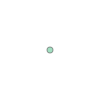

In [46]:
Malla_puntos[0]

In [47]:
Base_datos_lugares = None

MY_ID='DemoAppId01082013GAL'
CODE='AJKnXv84fjrb0KIHawS0Tg'

Base=pd.DataFrame()
Base_total=pd.DataFrame()

######### --------- Descarga para j puntos --------- #######
for j in range(0,10):
    Circulo_busqueda = Malla_puntos[j]
    Coordenadas_circulo = Circulo_busqueda.coords[0]
    ##### --------- Latitud y longitud ------ ######
    lat = Coordenadas_circulo[1]
    long = Coordenadas_circulo[0]

    distance_radio = 1000
    #Construccion de la url para la busqueda
    URL= "https://places.cit.api.here.com/places/v1/browse?"+\
    f"&in={lat},{long};r={distance_radio}" +\
    f"&app_id={MY_ID}"+\
    f"&app_code={CODE}"

    r=requests.get(url = URL)
    data = r.json()
    pre_resultados=data.get('results',None)
    try:
        pre_resultados=pd.DataFrame(pre_resultados)
        Lugares = pd.concat(list(pre_resultados['items'].apply(lambda items: pd.DataFrame({'Name':items['title'],'Distance':items['distance'],'Tipe': items['category']['title'],'lat': [items['position'][0]] , 'lon': [items['position'][1]] ,'Icon':items['icon']})))).reset_index(drop=True)

        Base_datos_lugares = pd.concat([Base_datos_lugares,Lugares],axis=0).reset_index(drop=True)
    except: 
        pass 


In [48]:
Base_datos_lugares=Base_datos_lugares.drop_duplicates('Name')

In [49]:
Base_datos_lugares

,Name,Distance,Tipe,lat,lon,Icon
0,Mariano Gold,10,Clothing & Accessories,4.667038,-74.052617,https://download.vcdn.cit.data.here.com/p/d/pl...
1,Priscila Lab,12,Clothing & Accessories,4.667000,-74.052584,https://download.vcdn.cit.data.here.com/p/d/pl...
2,La Hamburgueseria,12,Restaurant,4.667022,-74.052617,https://download.vcdn.cit.data.here.com/p/d/pl...
3,The Bros Brand,12,Clothing & Accessories,4.667077,-74.052650,https://download.vcdn.cit.data.here.com/p/d/pl...
4,Clonhadas,12,Clothing & Accessories,4.667077,-74.052650,https://download.vcdn.cit.data.here.com/p/d/pl...
...,...,...,...,...,...,...
195,Wabisabi,89,Restaurant,4.674890,-74.050250,https://download.vcdn.cit.data.here.com/p/d/pl...
196,Droguería San Remo,89,Shop,4.674510,-74.051510,https://download.vcdn.cit.data.here.com/p/d/pl...
197,Constructora-Geofundaciones S. A.,92,Service,4.673523,-74.051124,https://download.vcdn.cit.data.here.com/p/d/pl...
198,Trihunidos S. A. S.,92,Business & Services,4.673523,-74.051124,https://download.vcdn.cit.data.here.com/p/d/pl...


In [50]:
Mapa = folium.Map(location=[Base_datos_lugares.iloc[0]['lat'],Base_datos_lugares.iloc[0]['lon']],zoom_start=17,tiles='cartodbpositron')
##### ------- Centros circulos ----- ####### 
for lugar in range(0,len(Base_datos_lugares)):
    icon = folium.features.CustomIcon(Base_datos_lugares['Icon'].iloc[lugar],icon_size=(45, 45)) 
    folium.Marker([Base_datos_lugares.iloc[lugar]['lat'],Base_datos_lugares.iloc[lugar]['lon']],icon=icon,tooltip=Base_datos_lugares.iloc[lugar]['Name']).add_to(Mapa)



In [51]:
Mapa

In [55]:
### Google Places API
Text_search = 'Unicentro, Bogota, Colombia'

In [65]:
API_key_google = list(pd.read_excel('/Users/germangonzalez/Desktop/Secret.xlsx'))[0]

In [66]:
URL = 'https://maps.googleapis.com/maps/api/place/textsearch/json?query='+Text_search+'&key='+ str(API_key_google)
r=requests.get(url = URL)
data = r.json()
name = data['results'][0]['name']
Adress = data['results'][0]['formatted_address']
Id_google = data['results'][0]['place_id']
latitude = data['results'][0]['geometry']['location']['lat']
longitude = data['results'][0]['geometry']['location']['lng']
Type_of_place = data['results'][0]['types']
places = pd.DataFrame({'Name': [name],'Adress': [Adress],'Id_google': [Id_google],'latitude':[latitude],'longitude': [longitude], 'Type_of_place' : [Type_of_place] })






In [67]:
places

,Name,Adress,Id_google,latitude,longitude,Type_of_place
0,Unicentro,"Ak. 15 #124-30, Bogotá, Cundinamarca, Colombia",ChIJDySgbrKaP44RzUogN8V8YJY,4.70217,-74.04152,"[shopping_mall, point_of_interest, establishment]"


In [69]:
import populartimes

In [71]:
PopularTimes = populartimes.get_id(API_key_google, "ChIJDySgbrKaP44RzUogN8V8YJY")